<h1><center>Opmatch</center>
</h1>

<center>A lightweight package for optimal case-control matching.</center>

<h3 align="center">
    <a href="#-quick-tour">Quick Tour</a> &bull;
    <a href="#%EF%B8%8F-getting-started">Getting Started</a>
</h3>

## ⚡️ Getting Started
-------------------------

```bash
pip install opmatch
```
or
```bash
conda install -c conda-forge opmatch
```

## 🚀 Quick Tour
----------------------------------

### Generate Data

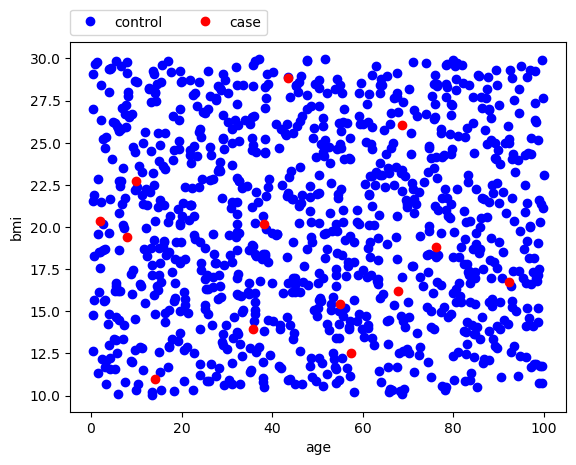

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

num_patients = 1000
age = np.random.uniform(0, 100, num_patients)
bmi = np.random.uniform(10, 30, num_patients)
case = np.random.binomial(1, .01, num_patients)
df = pd.DataFrame({'age':age, 'bmi':bmi, 'case':case})

plt.plot(df.age[df.case==0], df.bmi[df.case==0], 'bo', label='control')
plt.plot(df.age[df.case==1], df.bmi[df.case==1], 'ro', label='case')
plt.xlabel('age')
plt.ylabel('bmi')
plt.legend(loc=(0,1.02), ncol=2)

## Perform matching

In [ ]:
def match(df:pd.DataFrame, min_mr:int, 
         max_mr:int, n_controls:int, metric:str='PS',
         var_cols:List[str]=None, case_col:str='case')->dict:
    """
    df: has to contain 'case' column, 
        matching dictionary will be returned with dataframe indices
    min_mr: minimum number of controls per case
    max_mr: maximum number of controls per case
    n_controls: total number of controls, if constant matching ratio c required:
        min_mr=max_mr=c, n_controls=c*n_cases
    metric: PS or check https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html#scipy.spatial.distance.cdist
        distances
    var_cols: if Mahalanobis or Euclidian, columns that will be used for matching
    
    returns:
        {case0_id:[control00_id, control01_id,...], 
        case1_id:[control10_id, control11_id, ...]}
    """

    df_case = df[df[case_col]]
    df_control = df[~df[case_col]]
    case_ids = df_case.index
    control_ids = df_control.index
    
    n_case = len(case_ids)
    n_control_pool = len(control_ids)
    if isinstance(var_cols, type(None)):
        var_cols = df.columns
        var_cols.drop(case_col)
        warnings.warn('var_cols not specified, use all df columns, except for case column, to match on.')
    assert n_controls<=n_control_pool, f'n_controls={n_controls}>n_control_pool={n_control_pool}'
    # TODO: think about the line below
    #assert max_mr<=(n_controls-n_case+1), f'max_mr>(total_controls-n_case+1)={n_controls-n_case+1}'
    assert max_mr>=np.ceil(n_controls/n_case), f'max_mr<np.ceil(total_controls/n_case)={np.ceil(n_controls/n_case)}'
    assert min_mr<=np.floor(n_controls/n_case), f'min_mr>np.floor(n_controls/n_case)={np.floor(n_controls/n_case)}'
    assert min_mr>=1, 'min_mr<1'
    
    if metric=='PS':
        case_ps = df_case.ps.to_numpy()
        control_ps = df_control.ps.to_numpy()
        dist_mat = metrics.create_ps_dist_matrix(case_ps, control_ps, n_case, n_control_pool, 
                                min_mr, max_mr, n_controls)
    else:
        X_case = df_case[var_cols]
        X_control = df_control[var_cols]
        dist_mat = cdist(X_control, X_case, metric=metric)
    case_control_dmat = case_control_dist_mat(
            dist_mat, min_mr, 
            max_mr, n_case, n_control_pool,
            n_controls)

    match_result = linear_sum_assignment(case_control_dmat)
    case_control_dic = get_case_control_dic(match_result, case_ids, control_ids, max_mr)
    return case_control_dic


In [17]:
def pairwise_abs_dist(a:np.ndarray, b:np.ndarray):
    """Compute absolute distance matrix.
    Input: 1d arrays a and b
    Returns: len(a)xlen(b) distance matrix
    """
    return np.abs(a[:,np.newaxis] - b[np.newaxis, :])

def create_ps_dist_matrix(case_ps:np.ndarray, control_ps:np.ndarray, 
                    n_case:int, n_control:int, min_mr:int, 
                    max_mr:int, n_control_pool:int):
    K = n_case * max_mr - n_control_pool
    assert isinstance(K, int), 'make sure that max_mr and n_control_pool are integers'
    dist_mat = pairwise_abs_dist(case_ps, control_ps)
    return dist_mat


In [26]:
from typing import List
import warnings
class Matcher:
    def __init__(self, df:pd.DataFrame, matching_ratio:int=None, min_mr:int=None, 
        max_mr:int=None, n_controls:int=None, metric:str='PS',
        var_cols:List[str]=None, case_col:str='case', ps_col:str=None,
        matching_type:str='const') -> None:
        """matching_ratio: number of controls per case if constant matching ratio
        min_mr: minimum number of controls per case
        max_mr: maximum number of controls per case
        matching_type: 'const' or 'variable'
        var_cols: if metric is not PS, columns that will be used for matching
        case_col: column name of case column, should contain 1s and 0s
        """
        df[case_col] = df[case_col].astype(bool)
        self.df = df
        
        if matching_type=='const':
            assert isinstance(matching_ratio, int), 'Pass an integer to matching_ratio'
            n_case = self.df[case_col].sum()
            self.min_mr = matching_ratio
            self.max_mr = matching_ratio
            self.n_controls = matching_ratio*n_case 
        else:
            assert isinstance(min_mr, int), 'Pass an integer to min_mr'
            assert isinstance(max_mr, int), 'Pass an integer to max_mr'
            assert isinstance(n_controls, int), 'Pass an integer to n_controls'
            self.min_mr = min_mr
            self.max_mr = max_mr
            self.n_controls = n_controls

        self.metric = metric
        if isinstance(var_cols, type(None)):
            var_cols = df.columns
            var_cols.drop(case_col)
            warnings.warn('var_cols not specified, use all df columns, except for case column, to match on.')
        self.var_cols = var_cols
        self.case_col = case_col
        self.ps_col = ps_col
        case_mask = self.df[self.case_col]
        self.num_cases = self.df[case_mask].sum()
        self.num_control_pool = self.df[~case_mask].sum() 
        self.df_case = self.df[case_mask]
        self.df_control = self.df[~case_mask]
        self.case_ids = self.df_case.index
        self.control_ids = self.df_control.index

    def match(self):
        self.n_cases = len(self.case_ids)
        self.n_control_pool = len(self.control_ids)
        print(f'Number of cases: {self.n_cases}')
        print(f'Number of controls: {self.n_control_pool}')
        self.check_parameters()
        
        if self.metric=='PS':
            if isinstance(self.ps_col, type(None)):
                if 'ps' in self.df.columns:
                    self.ps_col = 'ps'
                elif 'PS' in self.df.columns:
                    self.ps_col = 'PS'
                else:
                    raise ValueError("Propensity score column name not passed, and 'ps'/'PS' not found in df")
            case_ps = self.df_case[self.ps_col].to_numpy()
            control_ps = self.df_control[self.ps_col].to_numpy()
            dist_mat = create_ps_dist_matrix(case_ps, control_ps, self.n_cases, self.n_control_pool, 
                                    self.min_mr, self.max_mr, self.n_controls)
            print('dist_mat.shape', dist_mat.shape)
            print('dist_mat', dist_mat)
            assert False
        else:
            X_case = df_case[var_cols]
            X_control = df_control[var_cols]
            dist_mat = cdist(X_control, X_case, metric=metric)
        case_control_dmat = case_control_dist_mat(
                dist_mat, self.min_mr, 
                self.max_mr, self.n_case, self.n_control_pool,
                self.n_controls)

        match_result = linear_sum_assignment(case_control_dmat)
        case_control_dic = get_case_control_dic(match_result, case_ids, control_ids, max_mr)
        return case_control_dic
    def check_parameters(self):
        assert self.n_controls<=self.n_control_pool, f'controls to match={self.n_controls}>{self.n_control_pool}=size of control pool'
        # TODO: think about the line below
        assert self.max_mr<=(self.n_controls-self.n_cases+1), f'max_mr>(total_controls-n_case+1)={self.n_controls-self.n_cases+1}'
        assert self.max_mr>=np.ceil(self.n_controls/self.n_cases), f'max_mr<np.ceil(total_controls/n_case)={np.ceil(self.n_controls/self.n_cases)}'
        assert self.min_mr<=np.floor(self.n_controls/self.n_cases), f'min_mr>np.floor(n_controls/n_case)={np.floor(self.n_controls/self.n_cases)}'
        assert self.min_mr>=1, 'min_mr<1'
    
    
        
            

In [29]:
df['ps'] = np.random.rand(len(df))

In [30]:
Matcher(df=df, matching_ratio=2, metric='PS', 
                    matching_type='const').match()

Number of cases: 13
Number of controls: 987


C:\Users\klein\AppData\Local\Temp\ipykernel_21196\149796774.py:36: UserWarning: var_cols not specified, use all df columns, except for case column, to match on.
  warnings.warn('var_cols not specified, use all df columns, except for case column, to match on.')


AssertionError: make sure that max_mr and n_control_pool are integers

d:\Thesis\opmatch\opmatch\util\variable_ratio_match.py:75: UserWarning: var_cols not specified, use all df columns, except for case column, to match on.
  warnings.warn('var_cols not specified, use all df columns, except for case column, to match on.')


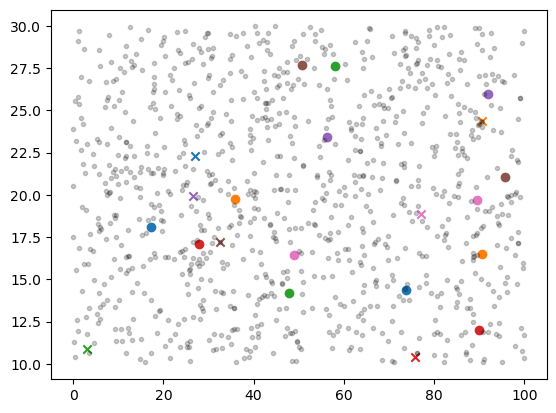

In [5]:
from opmatch import main
case_control_dic = main.match(df=df, matching_ratio=2, metric='Mahalanobis', 
                    matching_type='const')
fig, ax = plt.subplots()
# get colorwheel
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
matched = []
for color, (case, controls) in zip(colors, case_control_dic.items()):
    matched.extend(controls)
    matched.append(case)
    ax.scatter(df.loc[case, 'age'], df.loc[case, 'bmi'], color = color, marker = 'x')
    ax.scatter(df.loc[controls, 'age'], df.loc[controls, 'bmi'], color = color, marker='o')
unmatched = [i for i in df.index if i not in matched]
ax.scatter(df.loc[unmatched, 'age'], df.loc[unmatched, 'bmi'], color = 'k', marker='.', alpha=.2)